In [50]:
import pandas as pd

# Define column names from the dataset description
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]
 


In [51]:
train_df = pd.read_csv(
    r"D:\infosys_intern\SentinelNet_Oct_Batch\data\nsl-kdd\KDDTrain+.txt",
    header=None,
    names=column_names
)

train_df.drop(['difficulty'], axis=1, inplace=True)

test_df = pd.read_csv(
    r"D:\infosys_intern\SentinelNet_Oct_Batch\data\nsl-kdd\KDDTest+.txt",
    header=None,
    names=column_names
)

test_df.drop(['difficulty'], axis=1, inplace=True)


In [52]:

# Print dataset information
print("✅ Training Data:")
print(f"Shape: {train_df.shape}")
print(train_df.head())

print("\n✅ Testing Data:")
print(f"Shape: {test_df.shape}")
print(test_df.head())

✅ Training Data:
Shape: (125973, 42)
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2               

In [53]:
print("---training info ---")
train_df.info()

---training info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 n

In [54]:
print(train_df.isnull())

        duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0          False          False    False  False      False      False  False   
1          False          False    False  False      False      False  False   
2          False          False    False  False      False      False  False   
3          False          False    False  False      False      False  False   
4          False          False    False  False      False      False  False   
...          ...            ...      ...    ...        ...        ...    ...   
125968     False          False    False  False      False      False  False   
125969     False          False    False  False      False      False  False   
125970     False          False    False  False      False      False  False   
125971     False          False    False  False      False      False  False   
125972     False          False    False  False      False      False  False   

        wrong_fragment  urgent    hot  

In [55]:
print(f"shape : {test_df.shape}")
print(test_df.head())

shape : (22544, 42)
   duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         0           tcp   private   REJ          0          0     0   
1         0           tcp   private   REJ          0          0     0   
2         2           tcp  ftp_data    SF      12983          0     0   
3         0          icmp     eco_i    SF         20          0     0   
4         1           tcp    telnet  RSTO          0         15     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  10   
1               0       0    0  ...                   1   
2               0       0    0  ...                  86   
3               0       0    0  ...                  57   
4               0       0    0  ...                  86   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.04                    0.06   
1                    0.00                    0.06   
2                    0.61  

In [56]:
train_df['label'].value_counts()


label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [57]:
print(train_df.describe())

           duration     src_bytes     dst_bytes           land  \
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000   
mean      287.14465  4.556674e+04  1.977911e+04       0.000198   
std      2604.51531  5.870331e+06  4.021269e+06       0.014086   
min         0.00000  0.000000e+00  0.000000e+00       0.000000   
25%         0.00000  0.000000e+00  0.000000e+00       0.000000   
50%         0.00000  4.400000e+01  0.000000e+00       0.000000   
75%         0.00000  2.760000e+02  5.160000e+02       0.000000   
max     42908.00000  1.379964e+09  1.309937e+09       1.000000   

       wrong_fragment         urgent            hot  num_failed_logins  \
count   125973.000000  125973.000000  125973.000000      125973.000000   
mean         0.022687       0.000111       0.204409           0.001222   
std          0.253530       0.014366       2.149968           0.045239   
min          0.000000       0.000000       0.000000           0.000000   
25%          0.000000       0.00000

In [58]:
print(train_df.isnull().sum())


duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [59]:
#  Drop rows with missing values
train_df.dropna(inplace=True)

# Fill missing values 
train_df.fillna(0, inplace=True)


In [60]:
#data visualization for some data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional styling
sns.set(style="whitegrid")


In [61]:
print(train_df.columns)


Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label'],
      dtype='object')


In [62]:
 # 0 = Normal, 1 = Attack
train_df['attack_binary'] = train_df['label'].apply(lambda x: 0 if x=='normal' else 1)
test_df['attack_binary'] = test_df['label'].apply(lambda x: 0 if x=='normal' else 1)


C:\Users\HANIF\AppData\Local\Temp\ipykernel_12872\3093648034.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='attack_binary', data=train_df, palette='pastel')


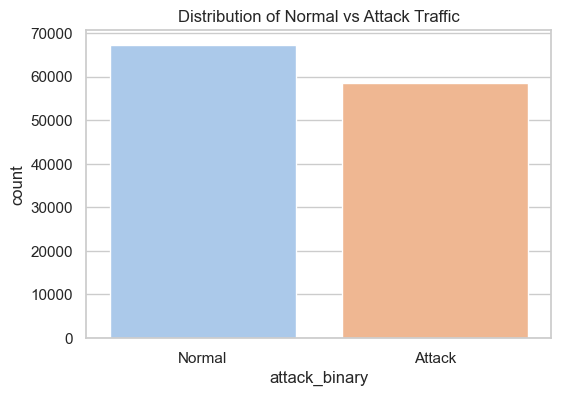

attack_binary
0    0.534583
1    0.465417
Name: proportion, dtype: float64


In [63]:
plt.figure(figsize=(6,4))
sns.countplot(x='attack_binary', data=train_df, palette='pastel')
plt.xticks([0,1], ['Normal','Attack'])
plt.title('Distribution of Normal vs Attack Traffic')
plt.show()

# Print percentages
print(train_df['attack_binary'].value_counts(normalize=True))


C:\Users\HANIF\AppData\Local\Temp\ipykernel_12872\2119583555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index, palette='Set2')


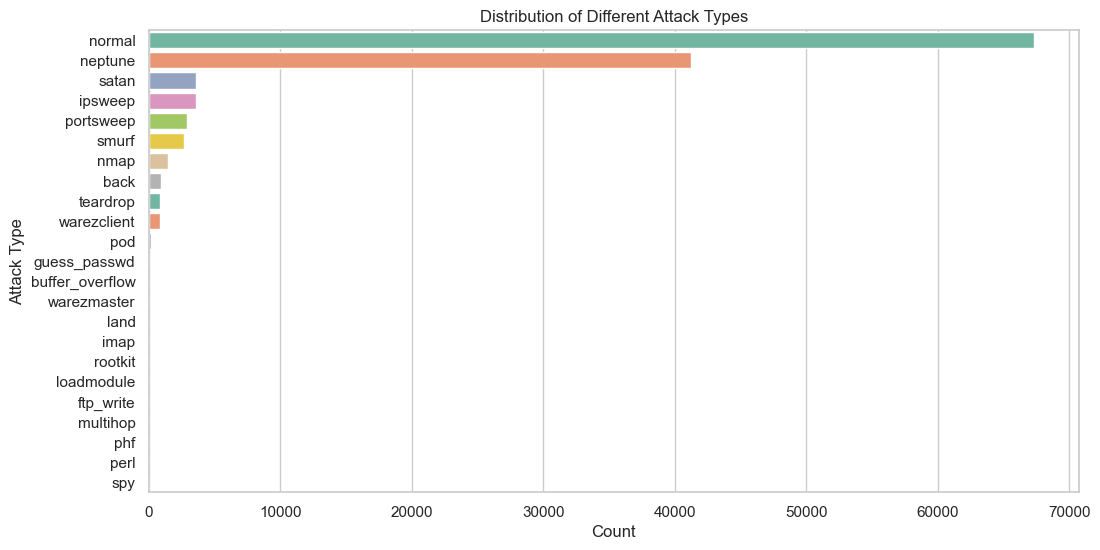

In [64]:
plt.figure(figsize=(12,6))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().index, palette='Set2')
plt.title('Distribution of Different Attack Types')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()


C:\Users\HANIF\AppData\Local\Temp\ipykernel_12872\444300889.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='protocol_type', data=train_df, palette='Set1')


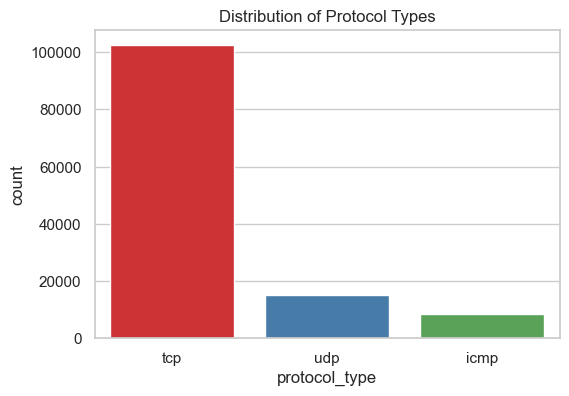

In [65]:
plt.figure(figsize=(6,4))
sns.countplot(x='protocol_type', data=train_df, palette='Set1')
plt.title('Distribution of Protocol Types')
plt.show()


C:\Users\HANIF\AppData\Local\Temp\ipykernel_12872\3912116912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='service', data=train_df[train_df['service'].isin(top_services)], order=top_services, palette='Set3')


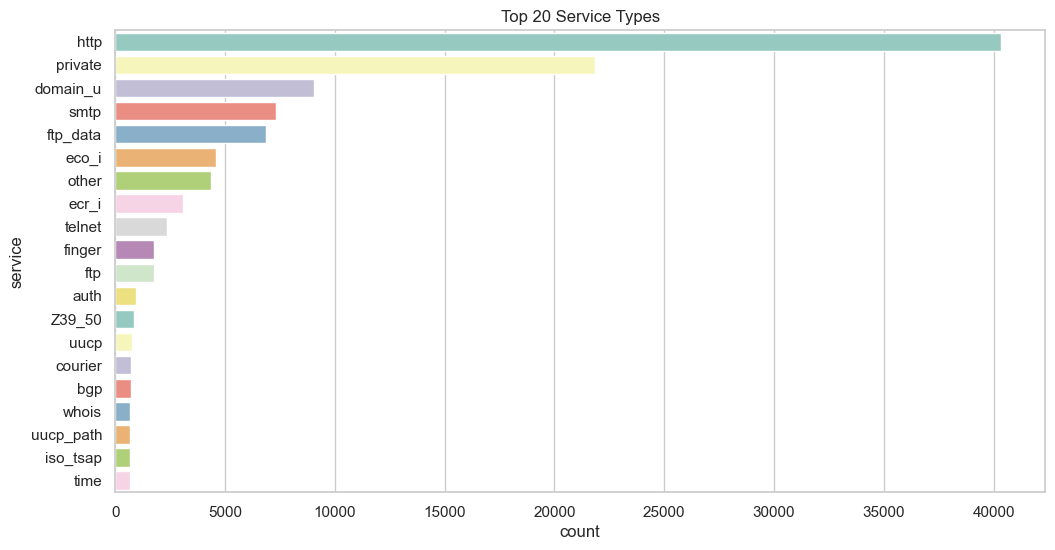

In [66]:
plt.figure(figsize=(12,6))
top_services = train_df['service'].value_counts().nlargest(20).index
sns.countplot(y='service', data=train_df[train_df['service'].isin(top_services)], order=top_services, palette='Set3')
plt.title('Top 20 Service Types')
plt.show()


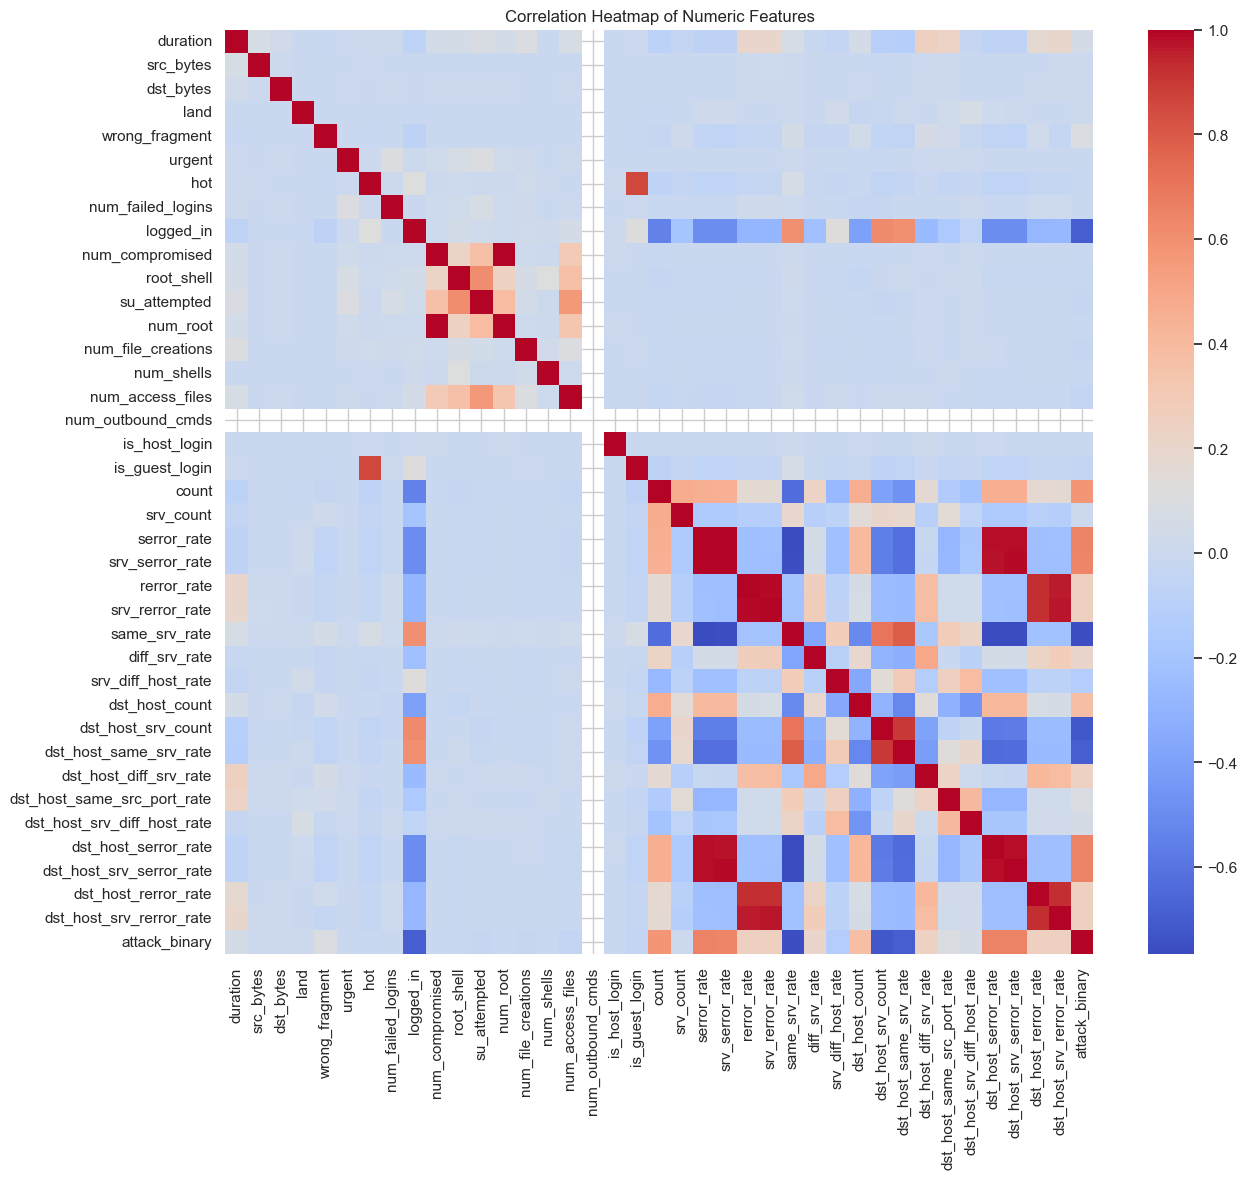

In [67]:
numeric_cols = train_df.select_dtypes(include='number').columns

plt.figure(figsize=(14,12))
sns.heatmap(train_df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


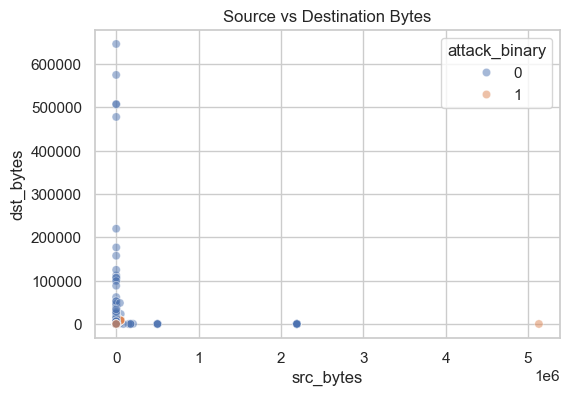

In [68]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='src_bytes', y='dst_bytes', hue='attack_binary', data=train_df.sample(5000), alpha=0.5)
plt.title('Source vs Destination Bytes')
plt.show()


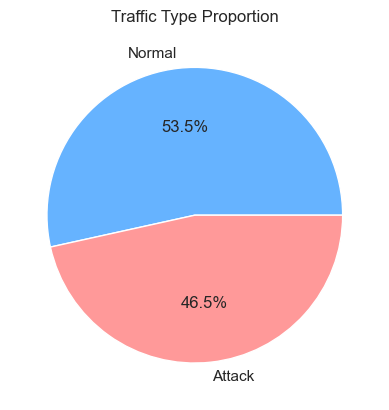

In [69]:
train_df['attack_binary'].value_counts().plot.pie(
    autopct='%1.1f%%', labels=['Normal','Attack'], colors=['#66b3ff','#ff9999']
)
plt.title('Traffic Type Proportion')
plt.ylabel('')
plt.show()
